In [1]:
tnt = require 'torchnet'
image = require 'image'

In [2]:
train = torch.load('../data/train.t7')
test = torch.load('../data/test.t7')
DATA_PATH = "../data"
WIDTH, HEIGHT = 32, 32

In [27]:
function transformInput(inp, theta_max, width, height)
  f = tnt.transform.compose{
      [1] = function(img) return image.rotate(img, torch.uniform(- theta_max, theta_max), 'bilinear') end,
      [2] = function(img) return image.translate(img, torch.random(0, 10), torch.random(0, 10)) end,
      [3] = function(img) return image.scale(img, width + torch.random(-10, 10), height + torch.random(-10, 10), 'bicubic') end,
      [4] = function(img) return image.scale(img, width, height, 'bicubic') end
  }
  return f(inp)
end

In [24]:
function getTrainSample(dataset, idx)
    r = dataset[idx]
    classId, track, file = r[9], r[1], r[2]
    file = string.format("%05d/%05d_%05d.ppm", classId, track, file)
    -- Add transformInput here
    img = image.load(DATA_PATH .. '/train_images/'..file)
    return img, transformInput(img, 10 / 360 * math.pi, 48, 48)
end

function getTrainLabel(dataset, idx)
    return torch.LongTensor{dataset[idx][9]}
end

In [5]:
function getTestSample(dataset, idx)
    r = dataset[idx]
    file = DATA_PATH .. "/test_images/" .. string.format("%05d.ppm", r[1])
    return transformInput(image.load(file))
end

In [6]:
trainDataset = tnt.SplitDataset{
    partitions = {train=0.9, val=0.1},
    dataset = tnt.ShuffleDataset{
        dataset = tnt.ListDataset{
            list = torch.range(1, train:size(1)):long(),
            load = function(idx)
                return {
                    input =  getTrainSample(train, idx),
                    target = getTrainLabel(train, idx)
                }
            end
        }
    }
}

In [7]:
function getIterator(dataset)
    return tnt.DatasetIterator{
        dataset = tnt.BatchDataset{
            batchsize = 128,
            dataset = dataset
        }
    }
end

In [36]:
trainDataset:select('val')

In [37]:
iter = getIterator(trainDataset)

In [38]:
trainDataset:select('train')

In [39]:
trainDataset:size()

35288	


In [40]:
(35288+3920)/128

306.3125	


In [41]:
3920/128

30.625	


In [42]:
35288/128

275.6875	


In [43]:
iter.dataset

tnt.BatchDataset
{
  perm : function: 0x02daac78
  makebatch : function: 0x03d73500
  filter : function: 0x02daae48
  policy : include-last
  dataset : 
    tnt.SplitDataset
    {
      __partition : LongTensor - size: 1
      __names : 
        {
          train : 1
          val : 2
        }
      __partitionsizes : LongTensor - size: 2
      __dataset : 
        tnt.ShuffleDataset
        {
          __replacement : false
          __dataset : 
            tnt.ListDataset
            {
              load : function: 0x03d6a958
              list : LongTensor - size: 39209
            }
          __perm : LongTensor - size: 39209
          __sampler : function: 0x03d6b0c8
        }
    }
  batchsize : 128
}


In [44]:
Plot = require 'itorch.Plot'

In [66]:
training_images_width = torch.Tensor(trainDataset:size())
training_images_height = torch.Tensor(trainDataset:size())

iter = getIterator(trainDataset)

idx = 1

for d in iter() do
    for i, img in pairs(d.input) do
        training_images_width[idx] = img:size()[2]
        training_images_height[idx] = img:size()[3]
        idx = idx + 1
    end
end


In [67]:
plot = Plot():histogram(training_images_width):draw()
plot:title('Image Width histogram'):redraw()
plot:xaxis('Number'):yaxis('width'):redraw()

In [68]:
plot = Plot():histogram(training_images_height):draw()
plot:title('Image height histogram'):redraw()
plot:xaxis('Number'):yaxis('height'):redraw()

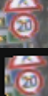

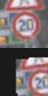

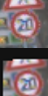

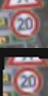

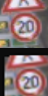

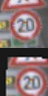

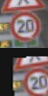

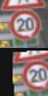

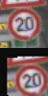

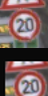

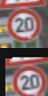

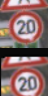

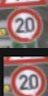

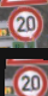

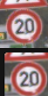

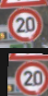

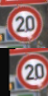

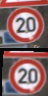

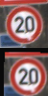

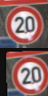

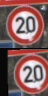

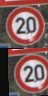

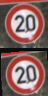

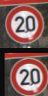

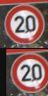

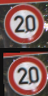

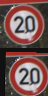

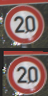

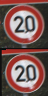

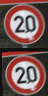

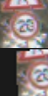

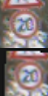

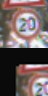

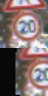

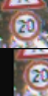

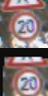

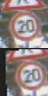

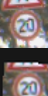

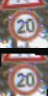

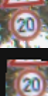

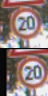

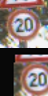

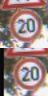

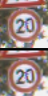

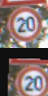

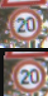

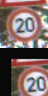

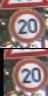

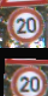

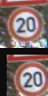

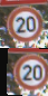

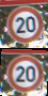

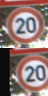

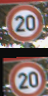

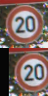

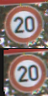

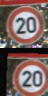

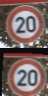

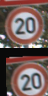

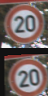

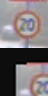

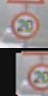

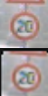

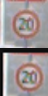

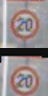

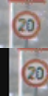

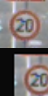

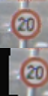

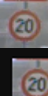

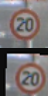

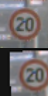

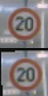

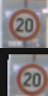

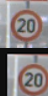

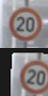

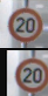

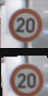

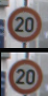

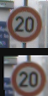

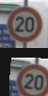

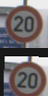

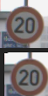

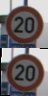

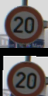

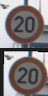

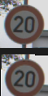

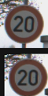

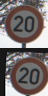

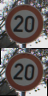

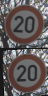

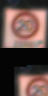

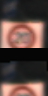

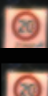

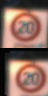

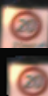

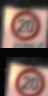

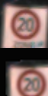

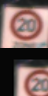

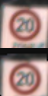

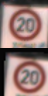

In [28]:
for idx = 1,100 do
    img_before, img_after = getTrainSample(train, idx)
    img = torch.cat(image.scale(img_before, 48, 48), img_after, 2)
    itorch.image(img)
end